In [7]:
import torch
from torch.nn import functional as F
import torch.nn as nn
from torchvision import datasets, transforms
from torchvision import models

import numpy as np
import random

from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.normal import Normal
import matplotlib.pyplot as plt

from Truncated import HMCTruncGaussian

In [117]:
x = torch.rand((32, 16))
eps = 1e-5

t = (x.var(dim=0, keepdim=True) + eps).sqrt()
print(t.shape)
t = t.repeat(x.shape[0], 1)
print(t.shape)

torch.Size([1, 16])
torch.Size([32, 32])


In [115]:
t.shape

torch.Size([32, 16])

In [24]:
mu = torch.rand((32, 64))
std = torch.rand((32, 64))

In [120]:
factor = 1
# mu: (32, 64)
def reparameterize(mu, std):
    dis = torch.distributions.Normal(0, 1)
    sample_shape = mu.shape
    negative_samples = dis.sample(sample_shape)
    prob_density = dis.log_prob(negative_samples)
    _, index_prob = torch.topk(-prob_density, sample_shape * 0.1)

    norm_data = negative_samples[index_prob]

    epsilon = norm_data * factor
    # epsilon = torch.randn_like(std) * factor
    return mu + epsilon * std

In [122]:
size = 500
a = torch.randn((1, size)) - 1.5
b = torch.randn((1, size)) - 1.5

a1 = torch.randn((1, size)) + 1.5
b1 = torch.randn((1, size)) + 1.5

x = torch.randn((1, size))
y = torch.randn((1, size))

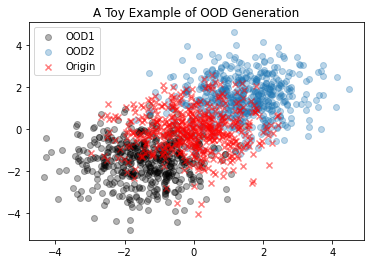

In [144]:
plt.scatter(a, b, marker='o', alpha=0.3, c='black', label="OOD1")
plt.scatter(a1, b1, marker="o", alpha=0.3, label="OOD2")
plt.scatter(x, y, marker="x", alpha=0.5, c = 'r', label="Origin")
plt.legend()
plt.title("A Toy Example of OOD Generation")
plt.savefig("./oodGenration.png", dpi=300)

In [49]:
def reparameterize(mu, std):
    dis = torch.distributions.Normal(0, 1)
    constraint_norm = []
    for i in range(mu.shape[0]):
        samples_size = mu[i].shape[0] * 100
        negtive_samples = dis.sample([samples_size,])
        prob_density = dis.log_prob(negtive_samples)
        _, index_prob = torch.topk(-prob_density, int(samples_size * 0.01))
        if constraint_norm == []:
            constraint_norm = negtive_samples[index_prob]
        else:
            torch.cat((constraint_norm, negtive_samples[index_prob]))

    epsilon = constraint_norm*factor
    return mu + epsilon * std




In [50]:
a = reparameterize(mu, std)
b = reparameterize(mu, std)
x = range(1, a[0].shape[0] + 1)

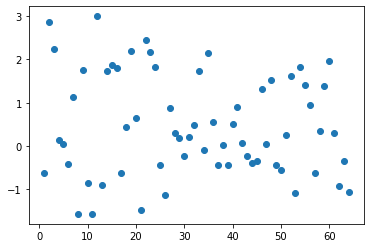

In [46]:
plt.scatter(x, a[0])

In [118]:
samples_size = 10000
ood_size = 0.1

multi_dis = torch.distributions.MultivariateNormal(torch.zeros(2), torch.eye(2)*150)
data = multi_dis.sample((samples_size,))
prob_density = multi_dis.log_prob(data)
cur_samples, index_prob = torch.topk(-prob_density, int(samples_size * ood_size))

ood_samples = []

# if ood_samples == []:
ood_samples = data[index_prob]
# else:
#     ood_samples = torch.cat((ood_samples, index_prob[index_prob]), 0)

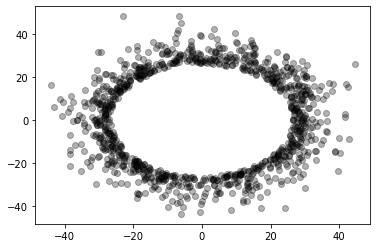

In [119]:
# plt.scatter(ood_samples.T[0], ood_samples.T[1])
plt.plot(ood_samples.T[0], ood_samples.T[1], 'ko', alpha=0.3)
plt.savefig("./ood", dpi=300)

In [48]:
samples_size = 100000
ood_size = 0.1

dis = torch.distributions.Normal(0, 1)
samples = dis.sample((samples_size,))
prob_density = dis.log_prob(samples)

cur_samples, index_prob = torch.topk(-prob_density, int(samples_size * ood_size))

ood_samples = []

if ood_samples == []:
    ood_samples = samples[index_prob]
else:
    ood_samples = torch.cat((ood_samples, index_prob[index_prob]), 0)

# *********************************
samples1 = dis.sample((samples_size,))
prob_density1 = dis.log_prob(samples1)

cur_samples1, index_prob = torch.topk(-prob_density1, int(samples_size * ood_size))
ood_samples1 = []

if ood_samples1 == []:
    ood_samples1 = samples1[index_prob]
else:
    ood_samples1 = torch.cat((ood_samples1, index_prob[index_prob]), 0)

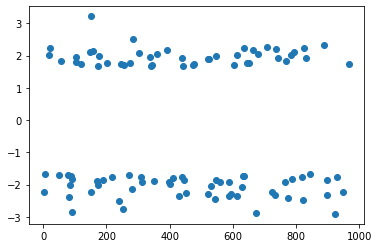

In [41]:
plt.scatter(index_prob, ood_samples1)

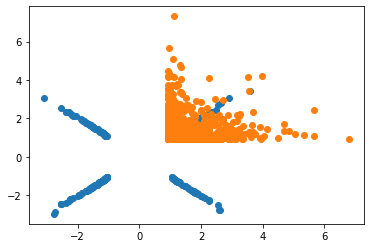

In [34]:
plt.scatter(ood_samples1, ood_samples)
# plt.scatter(samples1, samples)
plt.scatter(-prob_density, -prob_density1)

# plt.scatter(samples, prob_density)

In [34]:
import numpy as np
size = 2
mean = [0.1] * size
cov_mtx = np.identity(size)
Fc = np.identity(size)   # constraint matrix
# g = np.zeros((size,1)) + 2  # constraint vector
g = np.array([[-1], [1]])
initial = np.ones((size,1))
samples = 1000
a = HMCTruncGaussian().generate_general_tmg(Fc, g, cov_mtx, mean, initial, samples=samples)
b = HMCTruncGaussian().generate_general_tmg(Fc, g, cov_mtx, mean, initial, samples=samples)

In [ ]:
H = HMCTruncGaussian()
a = H.generate_simple_tmg([0], 1, samples=1000)
b = H.generate_simple_tmg([0], 1, samples=1000)

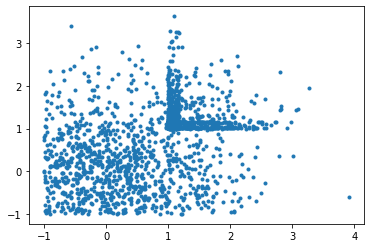

In [35]:
plt.scatter(a, b, marker=".")

In [105]:
import scipy
import math
from scipy import stats
import numpy as np

a = 1
sigma = 1
d = 2
n = 10000

u_max = scipy.stats.chi2.cdf((a/sigma)**2, d, scale=1)
u = np.random.uniform(0, 1, n*d) * u_max
# u = torch.rand(n*d) * u_max

cdf = lambda u : scipy.stats.chi2.isf(u, d)
# rho = sigma * math.sqrt(list(map(cdf, u)))
# rho = sigma * list(map(math.sqrt, list(map(cdf, u))))
rho = [sigma * i for i in list(map(math.sqrt, list(map(cdf, u))))]
# rho = sigma * math.sqrt(1-scipy.stats.chi2.cdf(1, d))
x = np.random.normal(0, 1, (n, d))

rho1 = torch.tensor(rho)
rho1 = rho1.view((-1, 2))
rho1 = rho1.numpy()

y1 = ((x * rho1)/np.linalg.norm(x, ord=2, axis=1).reshape(-1, 1)).T


In [95]:
x = range(1, len(y1[0])+1)

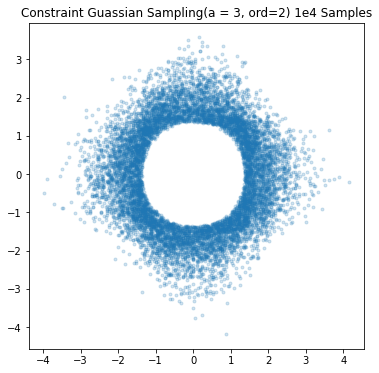

In [112]:
plt.figure(figsize=(6, 6))
plt.scatter(y1[0], y1[1], marker=".", alpha=0.2)
plt.title("Constraint Guassian Sampling(a = 3, ord=2) 1e4 Samples")
plt.savefig("./ord=2_1e4.png", dpi=300)
# plt.grid()

In [15]:
rho1 = torch.tensor(rho)
rho = rho1.view((-1, 2))
(rho * np.ndarray([10])).shape

C:\Users\USTCer\AppData\Local\Temp/ipykernel_11056/683371941.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rho1 = torch.tensor(rho)


ValueError: operands could not be broadcast together with shapes (1000,2) (10,) 

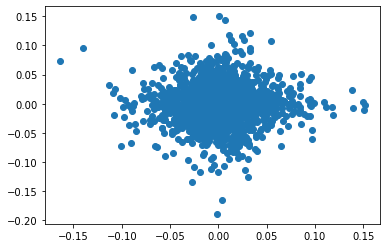

In [69]:
plt.scatter(y1, y2)

In [146]:
numofSample = 500

mu = torch.tensor([0., 5., 10.])
var = torch.tensor([1.,2.,1.])

m1 = MultivariateNormal(torch.tensor([mu[0], mu[0]]), torch.eye(2)*var[0])
data1 = m1.sample((numofSample,numofSample))

m2 = MultivariateNormal(torch.Tensor([mu[1], mu[1]]), torch.eye(2)*var[1])
data2 = m2.sample((numofSample, numofSample))

m3 = MultivariateNormal(torch.Tensor([mu[2], mu[2]]), torch.eye(2)*var[2])
data3 = m3.sample((numofSample, numofSample))

# mean_data = MultivariateNormal(torch.Tensor(4, 4), torch.eye(2)*0.5774)
mix = 0.3 * data1 + 0.7 * data2 

In [147]:
mean_data = mu.mean() + mu.var().sqrt() * torch.randn((numofSample, numofSample))
var_data = var.mean() + var.var().sqrt() * torch.randn((numofSample, numofSample))
mean_data = torch.unsqueeze(mean_data, 2)
var_data = torch.unsqueeze(var_data, 2)
statics = torch.cat((mean_data, var_data), dim=2)

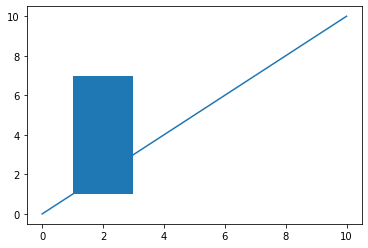

In [154]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

#define Matplotlib figure and axis
fig, ax = plt.subplots()

#create simple line plot
ax.plot([0, 10],[0, 10])

#add rectangle to plot
ax.add_patch(Rectangle((1, 1), 2, 6))

#display plot
plt.show()

In [186]:
from matplotlib.patches import Rectangle, Circle

def calculateRetangle(mu, sigma):
    # sigma = sigma * sigma
    dis = ((sigma)/2).sqrt()
    shift = 2.5

    return Rectangle((mu - shift*dis, mu - shift*dis), 
                    dis * 2 * shift, dis * 2 * shift, 
                    edgecolor='black', 
                    facecolor='black', fill=True
                    )

def PlotCircle(mu, sigma):
    dis = ((sigma)/2).sqrt()
    shift = 2.5

    return Circle((mu, mu), 
                    2 * sigma,
                    edgecolor='black',
                    facecolor='black', fill=False
                    )


In [187]:
def count(mu, sigma, data2=data2):
    dis = (sigma/2)
    count = 0
    for i in range(1000):
        if(data2[0][i][0]>=(mu-dis) and data2[0][i][1]<=(mu+dis)):
            # if(data2[1][i]>=mu-dis and data2[1][i]<=mu+dis):
            count += 1
        if(data2[1][i][0]>=(mu-dis) and data2[1][i][1]<=(mu+dis)):
            count += 1
    return count


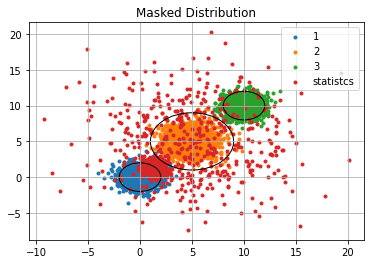

In [188]:
fig, ax = plt.subplots()
plt.scatter(data1[0], data1[1], marker=".", label="1")
plt.scatter(data2[0], data2[1], marker=".", label="2")
plt.scatter(data3[0], data3[1], marker=".", label="3")
# plt.scatter(mix[0], mix[1], marker=".", label="mix")
plt.scatter(statics[0], statics[1], marker=".", label="statistcs")
plt.grid()
# ax.add_patch(calculateRetangle(mu[1], var[1]))
# ax.add_patch(calculateRetangle(mu[0], var[0]))
# ax.add_patch(calculateRetangle(mu[2], var[2]))
ax.add_patch(PlotCircle(mu[1], var[1]))
ax.add_patch(PlotCircle(mu[0], var[0]))
ax.add_patch(PlotCircle(mu[2], var[2]))
# plt.text(data2[0][1][0], data2[0][1][0], '({}, {})'.format(data2[0][1][0], data2[0][1][1]))

plt.legend()
plt.title("Masked Distribution")
plt.savefig("./TruncateSampling.png", dpi=300)

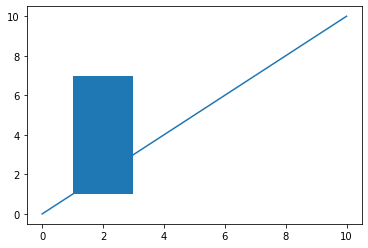

In [9]:
from matplotlib.patches import Rectangle
fig
Rectangle((1.,1.), 10, 10)


In [70]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

def Gaussian_Distribution(N=2, M=1000, m=0, sigma=1):
    '''
    Parameters
    ----------
    N 维度
    M 样本数
    m 样本均值
    sigma: 样本方差
    
    Returns
    -------
    data  shape(M, N), M 个 N 维服从高斯分布的样本
    Gaussian  高斯分布概率密度函数
    '''
    mean = np.zeros(N) + m  # 均值矩阵，每个维度的均值都为 m
    cov = np.eye(N) * sigma  # 协方差矩阵，每个维度的方差都为 sigma

    # 产生 N 维高斯分布数据
    data = np.random.multivariate_normal(mean, cov, M)
    # N 维数据高斯分布概率密度函数
    Gaussian = multivariate_normal(mean=mean, cov=cov)
    
    return data, Gaussian


In [25]:
data1, Gaussian1 = Gaussian_Distribution(m=0, sigma=1)

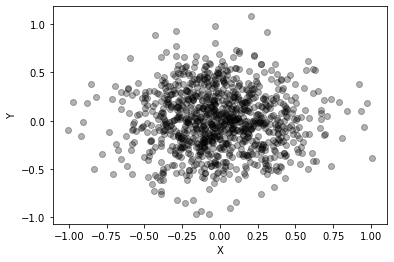

In [79]:
M = 1000
data, Gaussian = Gaussian_Distribution(N=2, M=M, sigma=0.1)
# 生成二维网格平面
# X, Y = np.meshgrid(np.linspace(-1,1,M), np.linspace(-1,1,M))
# 二维坐标数据
# d = np.dstack([X,Y])
# 计算二维联合高斯概率
Z = Gaussian.pdf(d).reshape(M,M)

plt.figure()
plt.xlabel("X")
plt.ylabel("Y")
x, y = data.T
# x1, y1 = data1.T
# plt.plot(x1, y1)
plt.plot(x, y, 'ko', alpha=0.3)
# plt.contour(X, Y,
#             Z, 
#             alpha =1.0, zorder=10)

# plt.show()


In [2]:
a = torch.rand(32,3,224,224)
con = nn.Conv2d(3,2, kernel_size=1)
a = con(a)

In [3]:
b = torch.rand(a.shape)
b.shape

torch.Size([32, 2, 224, 224])

In [9]:
a.shape

torch.Size([32, 2, 224, 224])

In [10]:
model = models.resnet18(pretrained=True)

In [18]:
for i in list(model.children()):
    print(type(i))

<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.batchnorm.BatchNorm2d'>
<class 'torch.nn.modules.activation.ReLU'>
<class 'torch.nn.modules.pooling.MaxPool2d'>
<class 'torch.nn.modules.container.Sequential'>
<class 'torch.nn.modules.container.Sequential'>
<class 'torch.nn.modules.container.Sequential'>
<class 'torch.nn.modules.container.Sequential'>
<class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>
<class 'torch.nn.modules.linear.Linear'>


In [186]:
model.load_state_dict(torch.load("./model.pth.tar-100")["state_dict"])

<All keys matched successfully>

In [187]:
class FE(nn.Module):
    def __init__(self, model):
        super(FE, self).__init__()
        self.model = model

    def forward(self, x):
        for i in list(self.model.children()):
            # if type(i) != nn.Linear and type(i) != nn.AdaptiveAvgPool2d:
            if type(i) != nn.Linear:
                x = i(x)
        return x

In [188]:
f =FE(model)

In [189]:
class FeatureExtractor(nn.Module):
    def __init__(self, model):
        super(FeatureExtractor, self).__init__()
        self.model = model
        self.layer1 = model.layer1
        self.layer2 = model.layer2
        self.layer3 = model.layer3
        self.layer4 = model.layer4

    def forward(self, x):
        x = self.model.bn1(self.model.conv1(x))
        x = self.model.maxpool(self.model.relu(x))
        x1 = self.layer1(x)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)
        x5 = self.model.avgpool(x4)
        return x1

In [190]:
f = FeatureExtractor(model)

In [191]:
from PIL import Image
image = Image.open("./dog.jpg")

In [192]:
transform = transforms.Compose([
    transforms.Resize(224), # 缩放图片(Image)，保持长宽比不变，最短边为224像素
    transforms.CenterCrop(224), # 从图片中间切出224*224的图片
    transforms.ToTensor(), # 将图片(Image)转成Tensor，归一化至[0, 1]（直接除以255）
    # transforms.Normalize(mean=[.5, .5, .5], std=[.5, .5, .5]) # 标准化至[-1, 1]，规定均值和标准差
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # 常用标准化
])

In [193]:
image = transform(image)

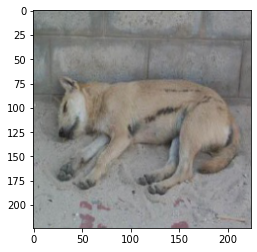

In [194]:
import matplotlib.pyplot as plt
img = np.transpose(image, (1,2,0))
plt.imshow(img)

In [195]:
image = np.expand_dims(image, 0)
image = torch.from_numpy(image)

In [196]:
image.shape

torch.Size([1, 3, 224, 224])

In [197]:
out = f(image)

In [198]:
out1, out2 = torch.chunk(out,2,dim=3)
out1.shape

torch.Size([1, 64, 56, 28])

In [199]:
def visualize_component(component, name='Component'):
    # Channel_wise Pooling --> B x 1 x H x W
    CP = torch.mean(component, dim=1, keepdim=True)
    B, C, H, W = CP.shape

    # min max normalization
    CP = CP.view(B, -1)
    CP = CP - CP.min(dim=1)[0].unsqueeze(1)
    CP = CP / CP.max(dim=1)[0].unsqueeze(1)
    CP = CP.view(B, 1, H, W)

    B, C, H, W = CP.shape
    # 先进行下采样（双线性插值）size=[a,b] 还是右对齐，(H,W)->(224,224)
    CP_up = torch.nn.functional.interpolate(CP, size=[224, 224], mode='bilinear').repeat(1, 3, 1, 1)  # repeat：还原到三通道
    img_out = CP_up
    # img_out = torch.cat([x_org, CP_up], dim=3)
    from torchvision.utils import make_grid, save_image
    save_image(make_grid(img_out, nrow=8), "./"+name+".jpg")

In [200]:
visualize_component(out1, name="1")
visualize_component(out2, name="2")
visualize_component(out, name="Total")

E:\Anaconda\lib\site-packages\torch\nn\functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


torch.chunk(input, chunks, dim = 0)

torch.split(tensor, split_size_or_sections, dim = 0)


In [201]:
def c(x, dim=1):
    x1, x2 = torch.chunk(x, 2, dim)
    return torch.chunk(x, 2, dim)

In [202]:
x1= c(out)

In [203]:
a = torch.rand([16,256,1,1])

In [204]:
import torch.nn as nn
flatten = nn.Flatten(1,3)

In [205]:
flatten(a).shape

torch.Size([16, 256])